In [4]:
!pip install tqdm

    100% |################################| 51kB 1.6MB/s ta 0:00:01


In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Reshape, LeakyReLU, Activation
from keras.activations import sigmoid
import tensorflow as tf

from utilities import show_graph

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

In [6]:
mnist = input_data.read_data_sets('./data', one_hot=False)
image_size = (28, 28, 1)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [14]:
# tf.reset_default_graph()
def discriminator(print_summary=False):
    with tf.variable_scope('discriminator'):
        discriminator = Sequential()
        discriminator.add(Conv2D(32, (5, 5), strides=2,
                         padding='same', input_shape=image_size))
        discriminator.add(LeakyReLU())
        discriminator.add(Conv2D(64, (5, 5), strides=2,
                         padding='same', input_shape=image_size))
        discriminator.add(BatchNormalization())
        discriminator.add(LeakyReLU())
        discriminator.add(Flatten())
        discriminator.add(Dense(1, activation='sigmoid'))
    
    if print_summary:
        print(discriminator.summary())
        
    return discriminator

In [15]:
def generator(print_summary=False):
    z_dim = 100
    depth = 128
    with tf.variable_scope('generator'):
        generator = Sequential()
        generator.add(Dense(7*7*depth, input_dim=z_dim))
        generator.add(Reshape((7,7,depth)))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU())

        depth = int(depth/2)
        generator.add(Conv2DTranspose(depth, 5, padding='same', strides=2))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU())

        depth = int(depth/2)
        generator.add(Conv2DTranspose(depth, 5, padding='same', strides=1))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU())

        depth = int(depth/2)
        generator.add(Conv2DTranspose(depth, 5, padding='same', strides=1))
        generator.add(BatchNormalization())
        generator.add(LeakyReLU())

        # depth = int(depth/2)
        generator.add(Conv2DTranspose(1, 5, padding='same', strides=2))
        generator.add(BatchNormalization())
        generator.add(Activation(sigmoid))
    
    if print_summary:
        print(generator.summary())
        
    return generator

In [16]:
def adversarial_model(generator, discriminator, print_summary=False):
    adversarial_model = Sequential()
    adversarial_model.add(generator)
    discriminator.trainable = False
    adversarial_model.add(discriminator)
    if print_summary:
        adversarial_model.summary()
    return adversarial_model

In [17]:
def mnist_gen(batch_size):
    while 1:
        data = mnist.train.next_batch(batch_size)
        yield data[0].reshape((-1,)+image_size)

In [18]:
batch_size = 128
z_dim = 100
mnist_data = mnist_gen(batch_size)

d = discriminator()
g = generator()
d_on_g = adversarial_model(g, d)
# d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
# g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
g.compile(loss='binary_crossentropy', optimizer="adam")
d_on_g.compile(loss='binary_crossentropy', optimizer="adam")
d.trainable = True
d.compile(loss='binary_crossentropy', optimizer="adam")


In [54]:
def plot_sample(imgs):
    sample_imgs = imgs[:9]
    plt.figure(figsize=(12,12))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(sample_imgs[i].squeeze(), cmap='gray')

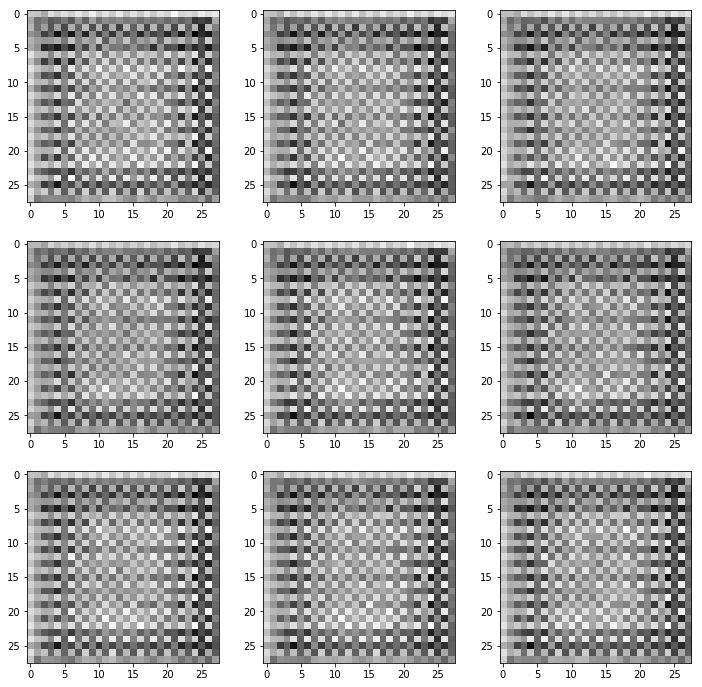

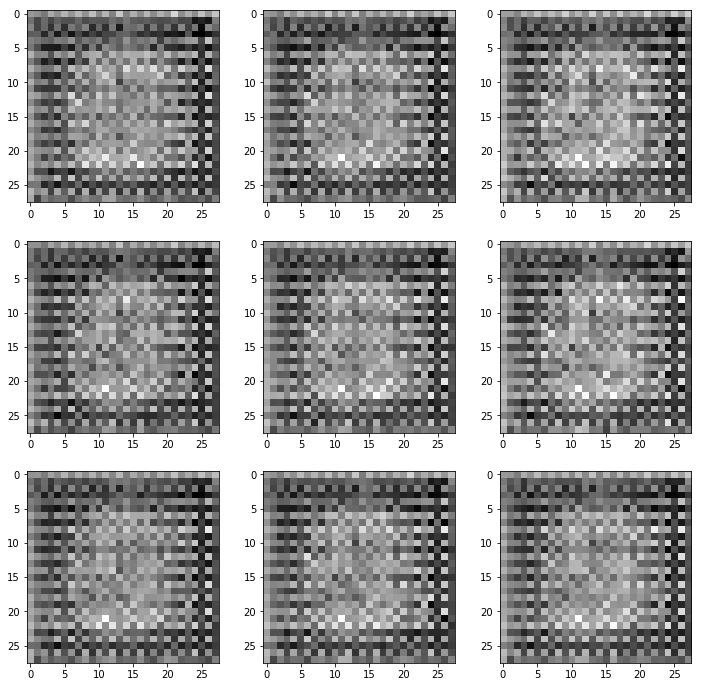

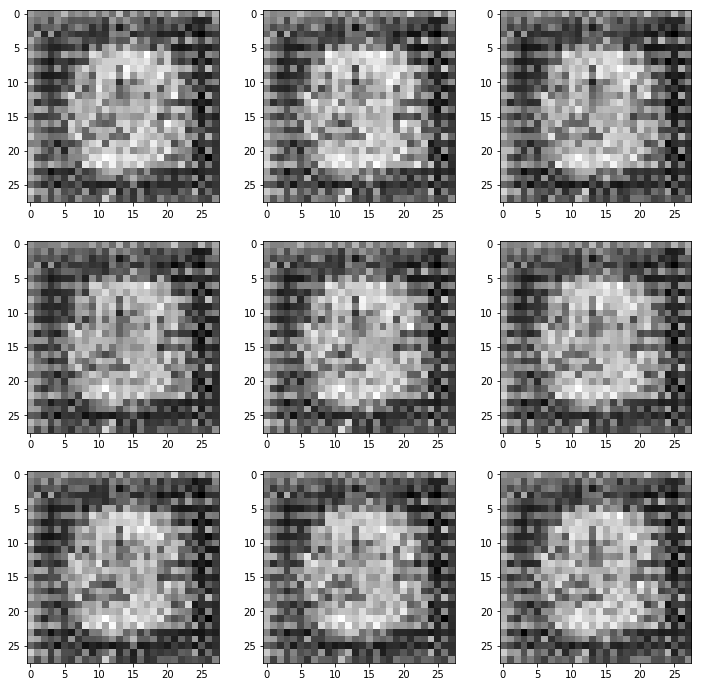

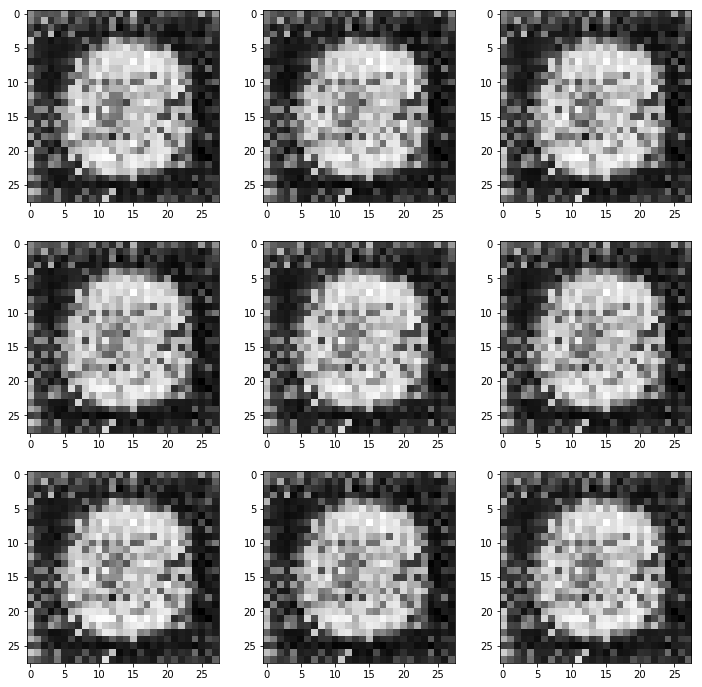

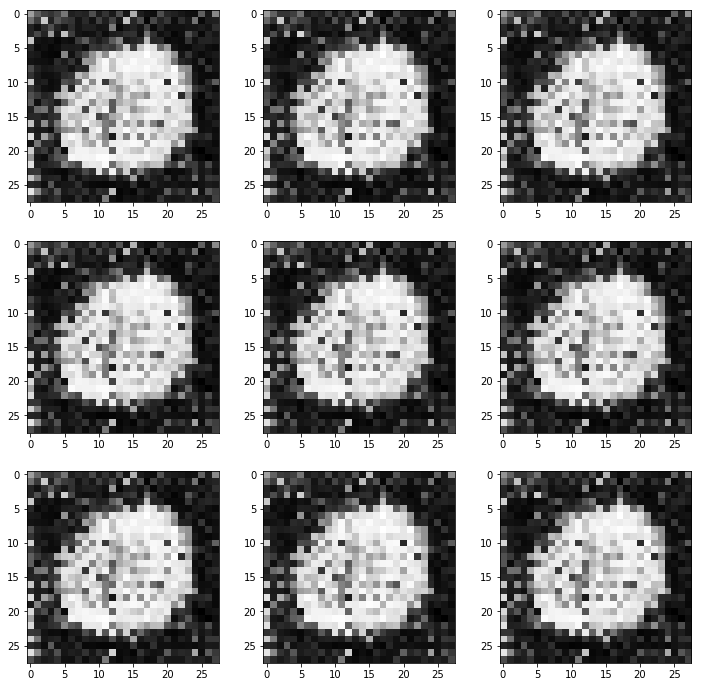

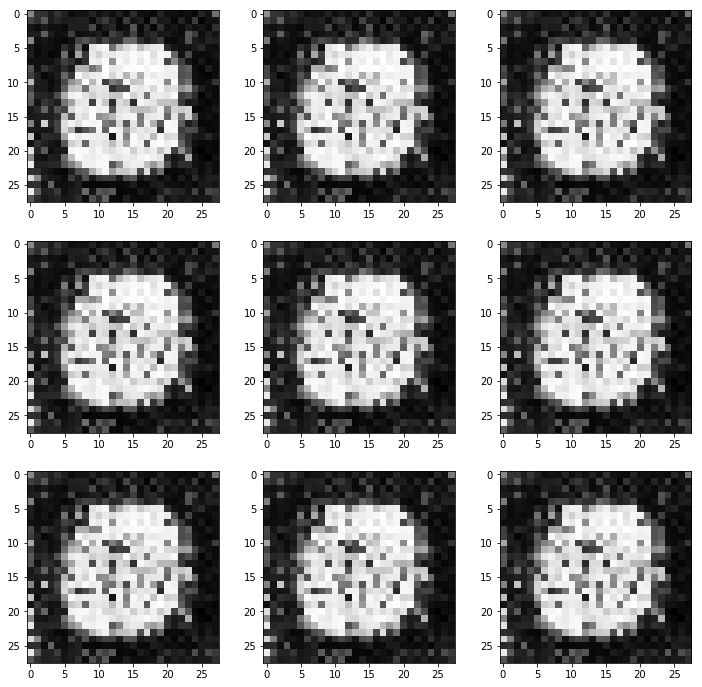

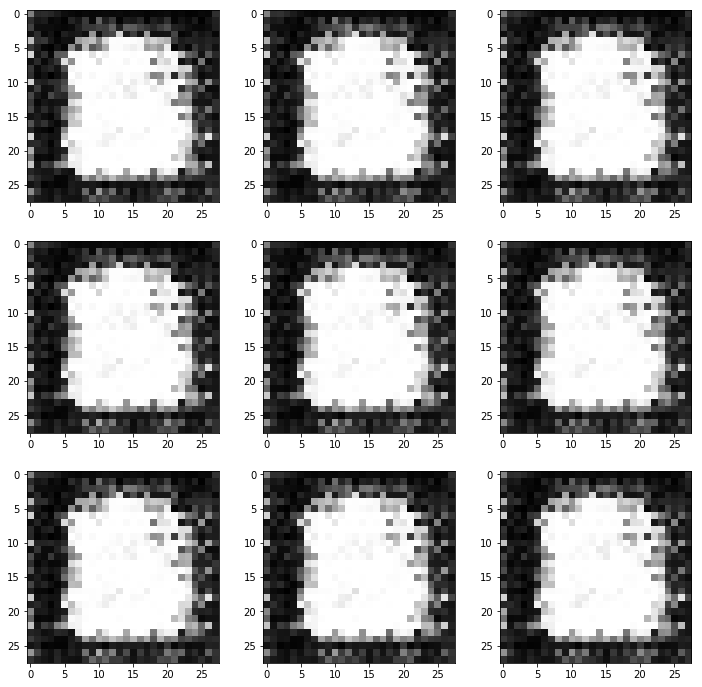

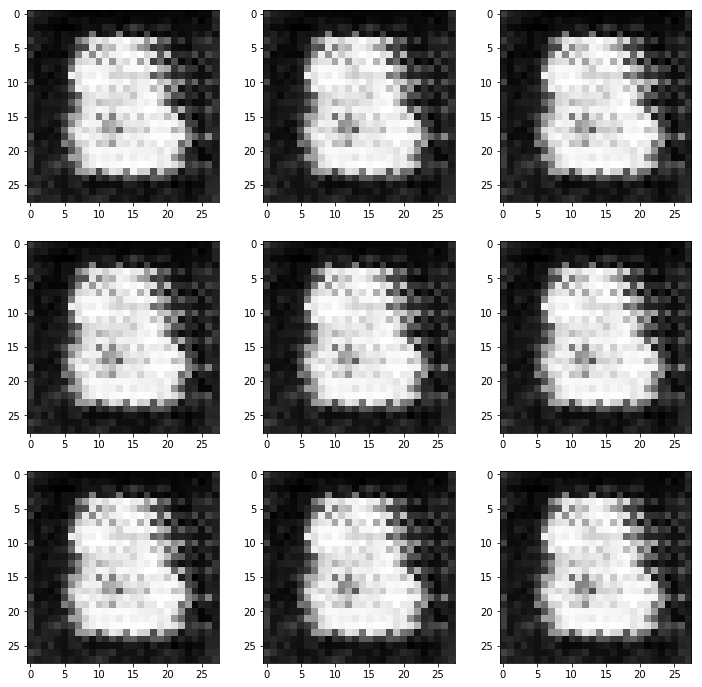

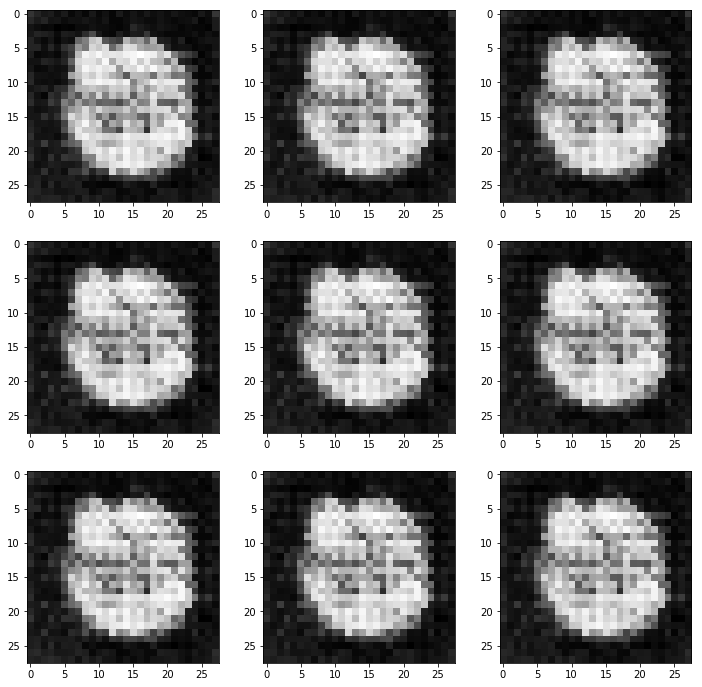

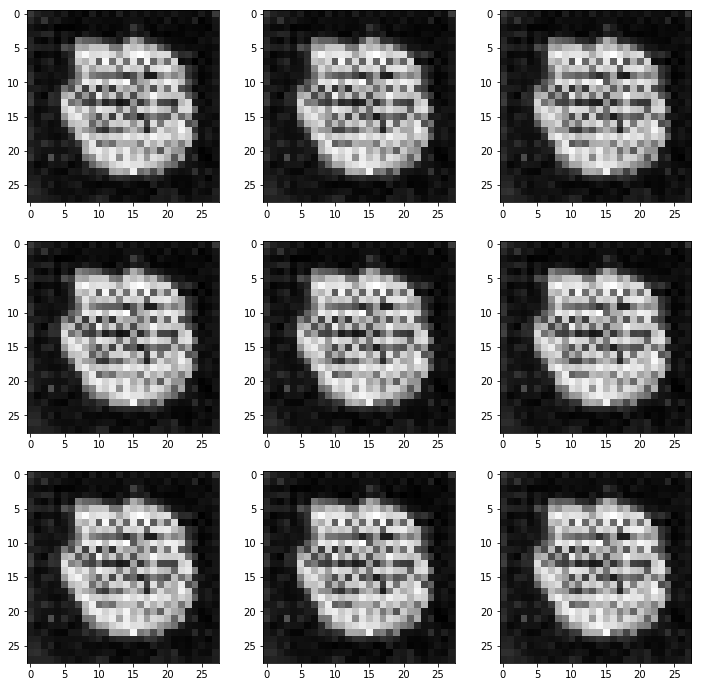

In [57]:
g_loss = []
d_loss = []
for i in range(1000):
    image_batch =  next(mnist_data)
    noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    generated_images = g.predict(noise, verbose=0)
    
    X = np.concatenate((image_batch, generated_images))
    y = [1] * batch_size + [0] * batch_size
    d.trainable = True
    d_loss.append(d.train_on_batch(X, y))

    y = np.ones((batch_size, 1))
    d_on_g.layers[1].trainable = False # Set discriminator training to false
    g_loss.append(d_on_g.train_on_batch(noise, y))
    if i % 100 == 0:
        plot_sample(generated_images)

In [58]:
show_graph(tf.get_default_graph().as_graph_def())